In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA





In [3]:
T2D_f = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_fuctional.csv",sep=",")
T2D_tax = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_taxo.csv",sep=",")
T2D_gen = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_gen40.csv",sep=",")
T2D_labels = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_ylab.txt")
T2D_labels= T2D_labels.iloc[:-1]
T2D_labels = T2D_labels[:].values
T2D_labels= pd.DataFrame(T2D_labels)
T2D_labels = T2D_labels.replace({"Control": 1, "T2D": 0})

CRC_f = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_Fuctional.csv",sep=",")
CRC_tax = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_Taxo.csv",sep=",")
CRC_gen = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_gen40.csv",sep=",")
CRC_labels = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_ylab.txt")
CRC_labels= CRC_labels.iloc[:-1]
CRC_labels = CRC_labels[:].values
CRC_labels= pd.DataFrame(CRC_labels)
CRC_labels = CRC_labels.replace({"control": 1, "CRC": 2})

IBD_f = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_fuctional.csv",sep=",")
IBD_tax = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_taxo.csv",sep=",")
IBD_gen = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_gen40.csv",sep=",")
IBD_labels = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_ylab.txt")
IBD_labels= IBD_labels.iloc[:-1]
IBD_labels = IBD_labels[:].values
IBD_labels= pd.DataFrame(IBD_labels)
IBD_labels = IBD_labels.replace({"Normal": 1, "IBD": 3})


LC_f = pd.read_csv("../Data/Microbiome_data/LC_data/LC_Fuctional.csv",sep=",")
LC_tax = pd.read_csv("../Data/Microbiome_data/LC_data/LC_taxo.csv",sep=",")
LC_gen = pd.read_csv("../Data/Microbiome_data/LC_data/LC_gen40.csv",sep=",")
LC_labels = pd.read_csv("../Data/Microbiome_data/LC_data/LC_ylab.txt")
LC_labels= LC_labels.iloc[:-1]
LC_labels = LC_labels[:].values
LC_labels= pd.DataFrame(LC_labels)
LC_labels = LC_labels.replace({"Normal": 1, "Cirrhosis": 4})


In [4]:
f1 = torch.tensor(T2D_f.values)
f2 = torch.tensor(T2D_gen.values)
f3 = torch.tensor(T2D_tax.values)
f4 = torch.tensor(IBD_f.values)
f5 = torch.tensor(IBD_gen.values)
f6 = torch.tensor(IBD_tax.values)
f7= torch.tensor(CRC_f.values)
f8 = torch.tensor(CRC_gen.values)
f9= torch.tensor(CRC_tax.values)
f10 = torch.tensor(LC_f.values)
f11= torch.tensor(LC_gen.values)
f12 = torch.tensor(LC_tax.values)

l1 = torch.tensor(T2D_labels.values)
l2 = torch.tensor(IBD_labels.values)
l3 = torch.tensor(CRC_labels.values)
l4 = torch.tensor(LC_labels.values)


In [22]:
T2D_comb = torch.cat((f1,f2,f3), dim=1)
IBD_comb = torch.cat((f4,f5,f6), dim=1)
CRC_comb = torch.cat((f7,f8,f9), dim=1)
LC_comb = torch.cat((f10,f11,f12), dim=1)
compined = torch.cat((T2D_comb,IBD_comb,CRC_comb,LC_comb))

labels_combined = torch.cat((l1,l2,l3,l4))

Test1 = torch.cat((IBD_comb,))
TestL= torch.cat((l2,))

In [23]:
#Save it to tensor .pt objects
torch.save(labels_combined, '../Data/Tensors_objs/labels.pt')
torch.save(compined, '../Data/Tensors_objs/features.pt')
np.savetxt("test",Test1,delimiter =",")
np.savetxt("TestL",TestL,delimiter=",")
np.savetxt("Data", compined, delimiter=",")
np.savetxt("Labels", labels_combined, delimiter=",")


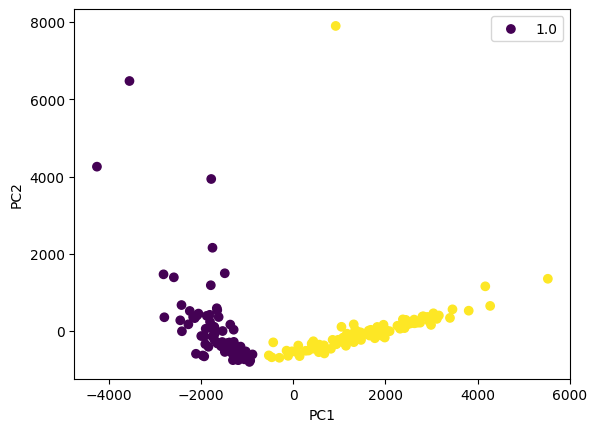

In [24]:


# Load your data into a numpy array called X
X = np.loadtxt("test", delimiter=",")
y = np.loadtxt("TestL")

# Separate your class labels from your feature data


# Apply PCA to reduce the dimensionality of your data to 2 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot your data in 2 dimensions, colored by class label
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.legend(y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [291]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        print(h1.shape)
        mu, logvar = self.fc21(h1), self.fc22(h1)
        print(mu.shape)
        print(logvar.shape)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.reshape(-1, self.input_dim).float())
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [367]:

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, num_classes):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim , hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
        # Activation function
        self.activation = nn.ReLU()
        
    def encode(self, x, y):
        # Concatenate input and target data
        x = torch.cat([x, y], dim=1)
        print(x.shape)
        
        # Pass through encoder network
        x = self.activation(self.fc1(x))
        #print(x.dtype)
        mu = self.fc21(x)
        #print(mu.dtype)
        logvar = self.fc22(x)
        #print(logvar.dtype)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Sample from the reparameterization trick
        std = torch.exp(0.5 * logvar)
        #print(std.shape)
        eps = torch.randn_like(std)
        #print(eps.shape)
        z = mu + eps * std
        return z
    
    def decode(self, z, y):
        # Concate target / latent 
        z = torch.cat([z, y], dim=1)
        print(z.shape)
        # Pass through decoder network
        z = self.activation(self.fc3(z))
        recon = self.fc4(z)
        #print(recon.shape)
        return recon
    
    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        recon = self.decode(z, y)
        #print(recon.shape)
        return recon, mu, logvar

def multiclass_vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.BCEWithLogitsLoss(reduction='sum')
    recon_loss = BCE(recon_x, x) / x.size(0)
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.size(0) * x.size(1)
    
    return recon_loss + KLD

def train_multiclass_vae(model, train_loader, optimizer, num_epochs):
    # Train the VAE for num_epochs epochs
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            recon, mu, logvar = model(data.float(),   target.float())
            print(recon.shape)
            print(mu.shape)
            print(logvar.shape)
            loss = multiclass_vae_loss(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    print('Epoch {}, Loss: {:.4f}'.format(epoch+1, total_loss / len(train_loader)))


In [393]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/Tensors_objs/features.pt")
labels = torch.load("../Data/Tensors_objs/labels.pt")
data = torch.DoubleTensor(data)
labels = labels.float()
labels = labels.double()
#labels = torch.DoubleTensor(labels)
#nan_indices = torch.isnan(data)
#data = torch.where(nan_indices, torch.tensor(0.0), data)


dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=10)

In [301]:
data.shape

torch.Size([636, 150])

In [385]:
model = VAE(10,2, 10,5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_multiclass_vae(model,dataloader,optimizer,5)

torch.Size([10, 151])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x151 and 15x10)

In [394]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

In [395]:
def vae_loss(x, x_hat, mu, log_var):
    # Reconstruction error
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    total_loss = (recon_loss + kld_loss)

    return total_loss


In [396]:
# Define the VAE model
input_size = 16 # size of each input feature
latent_size =2 # size of the latent variables
vae = VAE(input_size, latent_size)

# Define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Train the model
num_epochs = 50# number of epochs
batch_size =128 # size of each batch
data_loader =  dataloader # torch.utils.data.DataLoader for your dataset
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch_data in enumerate(data_loader):
        optimizer.zero_grad()

        x = batch_data
        x_hat, mu, log_var = vae(x)

        loss = vae_loss(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(data_loader.dataset)))


TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [97]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.cross_entropy(recon_x, x.reshape(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [98]:
def train_vae1(model, eex, epochs, batch_size, learning_rate):
    train_loader =  DataLoader(dataset, batch_size=20, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, eex in enumerate(train_loader):
           
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data.float())
            loss = loss_function(recon_batch, data.float(), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} \t Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

In [99]:
input_dim = 150 # Define the size of your input data
my_list = 2
z_dim = 150 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim,my_list, z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 50

In [209]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/Tensors_objs/features.pt")
labels = torch.load("../Data/Tensors_objs/labels.pt")
data = torch.DoubleTensor(data)
labels = labels.float()
labels = labels.double()
#labels = torch.DoubleTensor(labels)
nan_indices = torch.isnan(data)
data = torch.where(nan_indices, torch.tensor(0.0), data)


dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=128)

In [210]:
labels.dtype

torch.float64

In [386]:
train_vae1(model, dataloader, 50, 32, 1e-4)

TypeError: VAE.forward() missing 1 required positional argument: 'y'

In [102]:
torch.save(VAE.state_dict(model), '../Model/vae_one_study2.pth')

In [103]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae_one_study2.pth'))


<All keys matched successfully>

In [104]:
with torch.no_grad():
    z, _ = model.decode(data.float())

ValueError: too many values to unpack (expected 2)

In [68]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [69]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=5)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[4 1 0 2 1 0 1 4 4 1 1 2 0 4 0 3 1 3 1 1 1 1 3 1 3 3 4 0 4 1 0 3 4 2 1 1 1
 1 2 1 3 1 3 4 2 1 3 1 2 2 3 0 3 3 0 1 1 0 4 1 1 1 1 1 3 1 1 0 1 4 3 1 1 1
 1 1 1 2 4 1 0 1 4 4 4 4 2 1 1 1 1 0 3 1 4 1 1 4 4 1 1 0 3 4 4 1 1 4 0 1 1
 1 2 1 4 1 0 3 4 3 4 3 0 4 3 2 1 4]
1.0


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(compined, labels, test_size=0.2, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[1 1 3 4 3 4 4 3 4 0 1 1 1 1 4 1 1 0 0 0 2 4 1 1 4 1 1 1 1 1 1 1 1 2 4 1 4
 1 3 0 1 1 0 0 4 0 3 3 1 2 1 3 1 1 1 4 1 1 0 1 0 1 1 0 1 1 0 1 0 4 0 4 1 2
 4 1 1 3 1 1 4 1 1 1 1 4 3 4 1 3 4 3 0 2 3 4 2 3 2 1 1 1 1 2 0 1 1 4 1 1 1
 1 3 3 1 1 4 0 1 3 1 1 1 1 2 1 1 1]
0.9921875


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(compined, labels)
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 1.0000
Validation confusion matrix:
[[17  0  0  0  0]
 [ 0 66  0  0  0]
 [ 0  0  9  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 21]]


In [73]:
# Plot the decision boundaries and data points
x_min, x_max = test.min() - 0.1, test.max() + 0.1
y_min, y_max = test.min() - 0.1, test.max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


In [74]:

# first, find the indices of the points in class A and class B
indices_A = np.where(labels == 1)[0]
indices_B = np.where(labels == 0)[0]

In [75]:
indices_A

array([ 42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 344, 345, 346, 347, 348, 352, 353, 354, 355, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 368, 369, 370, 371,
       372, 373, 374, 376, 377, 378, 379, 381, 382, 383, 384, 38

In [76]:
# extract the data points (Tensors) in class A and class B
points_A = data[indices_A]
points_B = data[indices_B]

In [77]:
#  closest point in class B to the first point in class A
point_A = points_A[0]
distances = torch.norm(points_B - point_A, dim=1)
min_distance = torch.min(distances)
closest_point_B = points_B[torch.argmin(distances)]

In [78]:
# calculate the difference between the two points
difference = closest_point_B - point_A

print(f"The minimum Euclidean distance between a point in class A and a point in class B is {min_distance}.")
print(f"The closest point in class B to the first point in class A is {closest_point_B}.")
print(f"The difference between the two points is {difference}.")

The minimum Euclidean distance between a point in class A and a point in class B is 24.572020023521226.
The closest point in class B to the first point in class A is tensor([0.0000, 0.0000, 0.1819, 0.0000, 0.0000, 0.0000, 0.0000, 0.2239, 0.2333,
        0.1362, 0.1235, 0.0000, 0.0000, 0.0000, 0.1215, 0.1320, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1500, 0.0000, 0.0119, 0.0000, 0.0000, 0.0726,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2151, 0.0000, 0.0000, 0.1345,
        0.0000, 0.1855, 0.0000, 0.1912, 0.0000, 0.0000, 0.2760, 0.0000, 0.0666,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.2519, 0.0000, 0.0000, 1.2691,
        0.0000, 0.0000, 0.0000, 2.5403, 0.0000, 1.4951, 1.4841, 1.2158, 3.4579,
        0.0000, 0.2574, 1.5570, 0.0000, 3.4918, 1.1940, 0.0000, 0.0000, 0.1771,
        0.0000, 0.0000, 1.9311, 1.8469, 4.2595, 2.4102, 1.9308, 0.0000, 1.5183,
        4.4092, 0.0000, 0.4729, 0.0000, 0.2926, 2.7506, 0.0000, 0.0000, 2.1808,
        6.7957, 3.5056, 2.4417, 0.

In [42]:

indices = torch.where(torch.all(data == closest_point_B, axis=1))[0]


In [43]:
data[99]

tensor([0.0000, 1.9539, 1.0659, 0.0775, 0.0000, 0.4768, 0.0000, 0.0270, 0.0000,
        1.5593, 3.4844, 1.9633, 0.3306, 0.0000, 0.0000, 0.0000, 1.8488, 0.0000,
        1.3271, 0.0000, 0.0000, 0.0000, 0.0000, 1.9618, 0.0000, 3.0954, 1.7719,
        0.0000, 2.6623, 1.8815, 0.0000, 0.0000, 0.1827, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3736, 0.5692, 2.3507, 0.0347, 0.0000, 3.6566, 1.9310, 0.0000,
        0.0000, 2.7296, 2.5002, 0.0000, 1.0050, 2.2519, 0.0000, 0.0000, 1.2691,
        0.0000, 0.0000, 0.0000, 2.5403, 0.0000, 1.4951, 1.4841, 1.2158, 3.4579,
        0.0000, 0.2574, 1.5570, 0.0000, 3.4918, 1.1940, 0.0000, 0.0000, 0.1771,
        0.0000, 0.0000, 1.9311, 1.8469, 4.2595, 2.4102, 1.9308, 0.0000, 1.5183,
        4.4092, 0.0000, 0.4729, 0.0000, 0.2926, 2.7506, 0.0000, 0.0000, 2.1808,
        6.7957, 3.5056, 2.4417, 0.0000, 0.0000, 0.1032, 0.8042, 0.0991, 0.1461,
        3.3183, 2.2519, 0.0000, 0.0000, 1.2691, 0.0000, 0.0000, 0.0000, 2.5403,
        0.0000, 1.4951, 1.4841, 1.2158, 

In [79]:
single_tensor = torch.tensor(data[99])  # or any other single tensor
decoded_tensor = model.decode(single_tensor.unsqueeze(0).float())  # pass to the decoder of your VAE

/var/folders/wt/pl8gm0gs50d6vpk0nxfh07_h0000gn/T/ipykernel_20804/1601153969.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single_tensor = torch.tensor(data[99])  # or any other single tensor


In [80]:
import torch
from scipy.spatial.distance import cdist


# compute Euclidean distances between decoded tensor and all original tensors
distances = cdist(decoded_tensor.detach().numpy(), data.numpy(), metric='euclidean')

# find index of the original tensor with the smallest distance
index = torch.argmin(torch.from_numpy(distances))

# select the original tensor with the smallest distance
original_sample = dataset[index]

In [81]:
index

tensor(465)